# Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error
shap.initjs()
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Preparazione del datasaset completo

In [2]:
drugs_train_vecchio = pd.read_csv("drugsComTrain_raw.csv")
drugs_test_vecchio=pd.read_csv("drugsComTest_raw.csv")

In [3]:
drugs_train_vecchio.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
drugs_test_vecchio.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
print(len(drugs_train_vecchio))
print(len(drugs_test_vecchio))

161297
53766


In [6]:
# Uniamo i due dataset

drugs_complete = pd.concat([drugs_train_vecchio, drugs_test_vecchio], ignore_index=True)

In [7]:
drugs_complete.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [8]:
len(drugs_complete)

215063

In [9]:
#Valori unici per drugs_complete

drugs_complete.nunique()

uniqueID       215063
drugName         3671
condition         916
review         128478
rating             10
date             3579
usefulCount       397
dtype: int64

In [10]:
# Controlliamo se sono presenti valori nulli
drugs_complete.info()

# Notiamo che l'unica colonna con valori nulli è "condition", quindi possiamo decidere di eliminarli (1194 non hanno condition)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 11.5+ MB


In [11]:
drugs_complete_finale= drugs_complete.dropna()

In [12]:
drugs_complete_finale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213869 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     213869 non-null  int64 
 1   drugName     213869 non-null  object
 2   condition    213869 non-null  object
 3   review       213869 non-null  object
 4   rating       213869 non-null  int64 
 5   date         213869 non-null  object
 6   usefulCount  213869 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


# Statistiche descrittive

In [13]:
print("Statistiche descrittive (numeriche):")
print(drugs_complete_finale.describe())

print("\nStatistiche descrittive (categoriche):")
print(drugs_complete_finale.describe(include=['object']))

print("\nValori nulli per colonna:")
print(drugs_complete_finale.isnull().sum())

Statistiche descrittive (numeriche):
            uniqueID         rating    usefulCount
count  213869.000000  213869.000000  213869.000000
mean   116076.924786       6.991149      28.094118
std     67016.705794       3.275792      36.401377
min         0.000000       1.000000       0.000000
25%     58122.000000       5.000000       6.000000
50%    115972.000000       8.000000      16.000000
75%    174018.000000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000

Statistiche descrittive (categoriche):
              drugName      condition  review      date
count           213869         213869  213869    213869
unique            3667            916  128449      3579
top     Levonorgestrel  Birth Control  "Good"  1-Mar-16
freq              4896          38436      39       185

Valori nulli per colonna:
uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


In [14]:
var_numeric = drugs_complete_finale.select_dtypes(include=[np.number]).columns.tolist()
var_categorical = drugs_complete_finale.select_dtypes(include=['object']).columns.tolist()

In [15]:
var_numeric

['uniqueID', 'rating', 'usefulCount']

In [16]:
var_categorical

['drugName', 'condition', 'review', 'date']

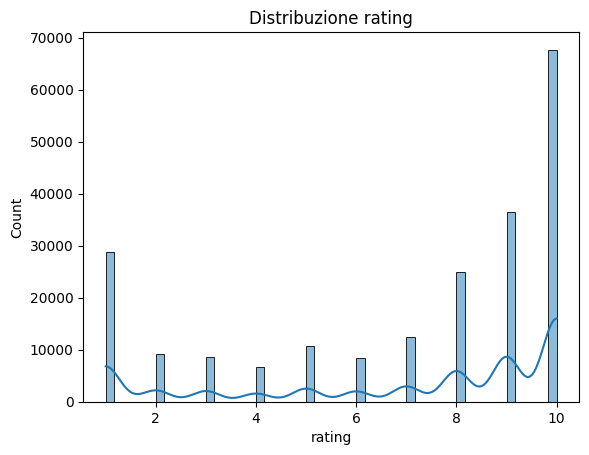

In [17]:
sns.histplot(drugs_complete_finale["rating"], kde=True)
plt.title("Distribuzione rating")
plt.show()

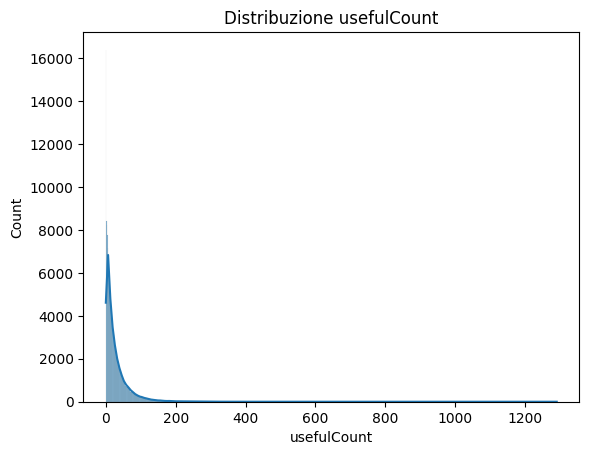

In [18]:
sns.histplot(drugs_complete_finale["usefulCount"], kde=True)
plt.title("Distribuzione usefulCount")
plt.show()

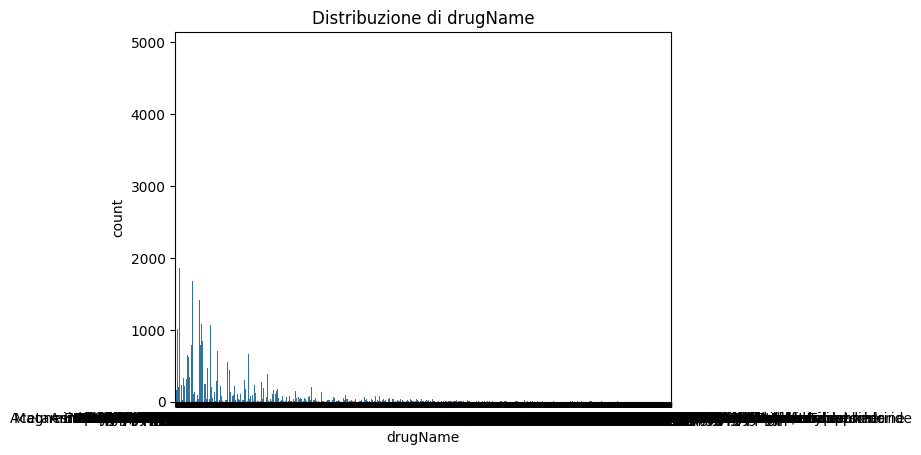

In [19]:
sns.countplot(x='drugName', data=drugs_complete_finale)
plt.title("Distribuzione di drugName")
plt.show()

# WordCloud

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # oppure 'italian'

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # rimuove punteggiatura
    text = re.sub(r'\d+', '', text)      # rimuove numeri
    text = re.sub(r's+', ' ', text) #rimuove doppi spazi


    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

[nltk_data] Downloading package stopwords to /Users/nico/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
drugs_complete_finale["clean_text"]=drugs_complete_finale["review"].apply(clean_text)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


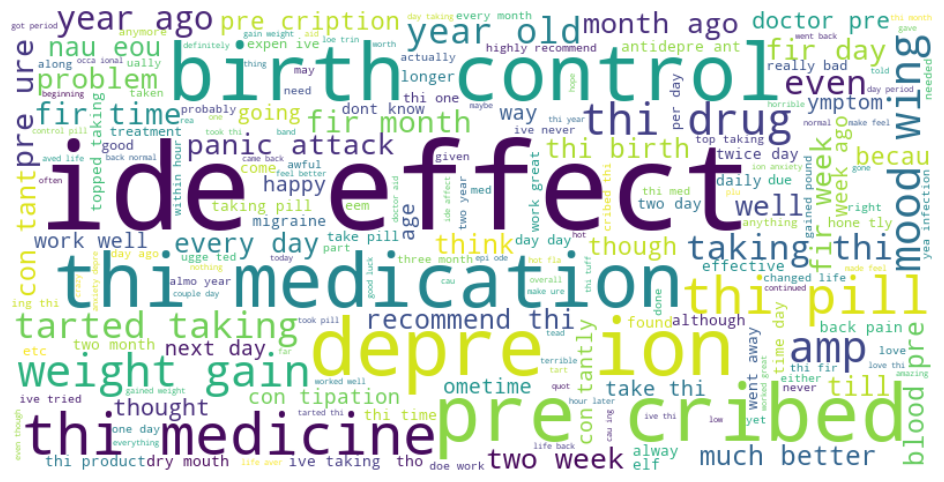

In [22]:
text_all = " ".join(drugs_complete_finale["clean_text"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Uniamo farmaco e condizione
drugs['farmaco_condizione'] = drugs['drugName'].astype(str) + " " + drugs['condition'].astype(str)

NameError: name 'drugs' is not defined

In [ ]:
# Uniamo farmaco e condizione  nella review
drugs['review'] = drugs['farmaco_condizione'] + " " + drugs['review'].astype(str) + " " + drugs['farmaco_condizione']